In [1]:
import numpy as np
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import pickle
from sklearn.metrics import accuracy_score
from scipy.stats import sem
from sklearn.metrics import roc_curve, auc
import cv2
import matplotlib.patches as patches
%matplotlib inline
import pickle
from shutil import copyfile

# Input

In [12]:
net = "FRCNN" # YOLO or FRCNN or Retinanet
# outputfilename = "output_retinanet_AIIMStest_ontrain_fold1_ep10.txt"
# outputfilename = "output_retinanet_AIIMStest_2.txt"
# outputfilename = "output_retinanet_smallmass.txt"
# outputfilename = "output_retinanet_masscal.txt"
# outputfilename = "output_retinanet_image_labelled_20000_full.txt"
# outputfilename = "mal_format_smallmass.txt"
# outputfilename = "mal_format_masscal.txt"
outputfilename = "mal_format.txt"
# path_to_gt = "/home/anvit/Desktop/RetinaNet/pytorch-retinanet/csv_annotation_AIIMStest_fold1_orig.csv"
# path_to_gt = "/home/anvit/Desktop/RetinaNet/pytorch-retinanet/csv_annotation_AIIMS_smallmass.csv"
# path_to_gt = "/home/anvit/Desktop/RetinaNet/pytorch-retinanet/csv_annotation_AIIMS_masscal.csv"
path_to_gt = "/home/anvit/Desktop/RetinaNet/pytorch-retinanet/csv_annotation_AIIMS_image_labelled_20000_full.csv"
# number_imgs = 692
# number_imgs = 78
# number_imgs = 857
number_imgs = 24570
# number_imgs = 5281
# data_img_path = "/home/anvit/Desktop/Data/AIIMS_Data/Both_labelled/AllSetsPNG_resized/"
# data_img_path = "/home/anvit/Desktop/Data/AIIMS_Data/smallmass_png_resized/"
data_img_path = "/home/anvit/Desktop/Data/AIIMS_Data/image_labelled_20000_resized/"
# data_xml_path = "/home/anvit/Desktop/Data/AIIMS_Data/smallmass_xml_resized/"
# data_xml_path = "/home/anvit/Desktop/Data/AIIMS_Data/smallmass_xml_resized/"
# data_xml_path = "/home/anvit/Desktop/Data/AIIMS_Data/Both_labelled/AllSetsXMLs_resized/"

In [13]:
# Count malignant, benign and normal in test set

fil = open(path_to_gt, 'r')
lines = fil.readlines()

malignant = []
normal = []
benign = []
allnames = []

for line in lines:
    line = line.strip('\n')
    arr = line.split(",")
    filepath = arr[0].split("/")
    name = filepath[-1]
    if name not in allnames:
        allnames.append(name)
    if arr[-1] == '':
        normal.append(name)
    elif arr[-1] == '1':
        if name not in malignant:
            malignant.append(name)


for f in allnames:
    if f not in normal and f not in malignant:
        benign.append(f)

print("Number of NORMAL images", len(normal))
print("Number of MALIGNANT images", len(malignant))
print("Number of BENIGN images", len(benign))
assert(len(normal) + len(benign) + len(malignant) == number_imgs)
fil.close()

Number of NORMAL images 11651
Number of MALIGNANT images 2527
Number of BENIGN images 10392


In [14]:
mal_dict = {} #GT
totalmallesions = 0
for filename in malignant:
    xml = filename[:-4] + ".xml"
    try:
        tree = ET.parse(data_xml_path + xml)
        root = tree.getroot()
        if(len(root.findall('object'))>0): # no objects but yes xml means it is BIRADS 0 or SN or something
            mal_dict[xml[:-4]] = []
        for obj in root.findall('object'):
            bbox = obj[4]
            xmin = bbox[0].text
            ymin = bbox[1].text
            xmax = bbox[2].text
            ymax = bbox[3].text

            temparr = [xmin, ymin, xmax, ymax, 0]
            mal_dict[xml[:-4]].append(temparr)
            totalmallesions += 1
        
    except:
        print("excepted")
        continue

print(totalmallesions)

excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
e

excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
excepted
e

In [15]:
# Assuming predictions for each malignant image in the form x_min, x_max, y_min, y_max for all lesions in a different row
# Image_name x_min, y_min, x_max, y_max malignant_confidence
# Assuming predictions sorted image wise

def getdicts(filename):
    if net == "YOLO":
        netpred = open("/home/anvit/Desktop/Scripts/YOLO_output_files/"+filename,'r')
    elif net == "FRCNN":
        netpred = open("/home/anvit/Desktop/Scripts/FasterRCNN_output_files/"+filename,'r')
    elif net == "Retinanet":
        netpred = open("/home/anvit/Desktop/RetinaNet/pytorch-retinanet/output_files/"+filename, 'r')

    predictions = netpred.readlines()
    #print(len(predictions))

    pred_dict = {}
    conf_dict = {}
    for row in predictions:
        row = row.rstrip()
        det = row.split(",")
        #print(det)
        if net == "Retinanet" and det[6] == "0":
            continue
        if(det[0][:-4] not in pred_dict):
            pred_dict[det[0][:-4]] = [[det[1], det[2], det[3], det[4]]]
            conf_dict[det[0][:-4]] = det[5]

        else:
            pred_dict[det[0][:-4]].append([det[1], det[2], det[3], det[4]])
            conf_dict[det[0][:-4]] = max(float(det[5]), float(conf_dict[det[0][:-4]]))
    
    netpred.close()
    
#     # Confidence = average confidence of all views
#     for l in conf_dict:
#         try:
#             otherview = modified_diction[l]
#             avg = (conf_dict[l] + conf_dict[otherview])/2
#             conf_dict[l] = avg
#             conf_dict[otherview] = avg
#         except:
#             continue

    return pred_dict, conf_dict

pred_dict, conf_dict = getdicts(outputfilename)
#print(pred_dict, conf_dict)

In [16]:
# Find malignant images with no predictions
keep = 0
for i in mal_dict:
    if i not in pred_dict:
        print(i)
        keep += 1
print(keep)

0


# CLASSIFICATION

In [17]:
testimages = []
testimages.extend(benign)
testimages.extend(malignant)
#testimages.extend(normal)
#assert(len(testimages) == number_imgs - len(normal))

testimages.sort()

gtlabel = []

for file in testimages:
    if(file in malignant):
        gtlabel.append(1)
    elif(file in benign):
        gtlabel.append(0.0)
    elif(file in normal):
        gtlabel.append(0)


predconf = []
normalasnormal = 0
for im in testimages:
    try:
        if(float(conf_dict[im[:-4]]) < 0.001):
            predconf.append(0)
        else:
            predconf.append(float(conf_dict[im[:-4]]))

#         if(im[:-4] in normal):
#             print(float(conf_dict[im[:-4]]))

    except:
#         if(im[:-4] in normal):
#             normalasnormal += 1
        predconf.append(0)

## ROC

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

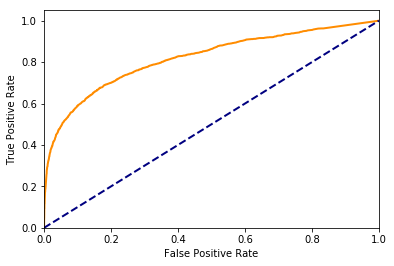

In [18]:
def plot_roc(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

print(gtlabel)
print(predconf)
print(roc_auc_score(gtlabel, predconf))
#pickle.dump({'gt': gtlabel, 'pred': predconf}, open('/home/anvit/Desktop/retinanet_roc_new.pk', "wb"))
fpr, tpr, threshold = roc_curve(gtlabel, predconf)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)
#0.9935064935064934
#[0.926, 0.892, 0.93, 0.803, 0.928, 0.817, 0.457, 0.922, 0.71, 0.89, 0, 0.938, 0.772, 0.768, 0.954, 0.91, 0.936, 0.93, 0.922, 0.973, 0.975, 0.905, 0.909, 0.873, 0, 0.395, 0.981, 0.983, 0.885, 0.769, 0.964, 0.951, 0.869, 0.79, 0.714, 0.88, 0.911, 0.97, 0.983, 0.895, 0.893, 0.912, 0.942, 0.727, 0.542, 0.907, 0.308, 0.758, 0.856, 0.852, 0.769, 0.892, 0.912, 0.882, 0.925, 0.319, 0.396, 0.455, 0.73, 0.891, 0.925, 0.929, 0.965, 0.909, 0.88, 0.831, 0.914, 0.976, 0.97, 0.98, 0.737, 0.858, 0.936, 0.93, 0.962, 0.713, 0.952, 0.975]

THRESHOLD: 0.0
2527 0 10392 0
ACCURACY = 0.19560337487421628
SENSITIVITY = 1.0
SPECIFICITY = 0
THRESHOLD: 0.05
2433 1725 8667 94
ACCURACY = 0.32185153649663284
SENSITIVITY = 0.962801741195093
SPECIFICITY = 0.1659930715935335
THRESHOLD: 0.1
2326 3369 7023 201
ACCURACY = 0.44082359315736513
SENSITIVITY = 0.9204590423426988
SPECIFICITY = 0.3241916859122402
THRESHOLD: 0.15
2246 4670 5722 281
ACCURACY = 0.5353355522873288
SENSITIVITY = 0.888800949742778
SPECIFICITY = 0.4493841416474211
THRESHOLD: 0.2
2133 5675 4717 394
ACCURACY = 0.6043811440513972
SENSITIVITY = 0.8440838939453897
SPECIFICITY = 0.5460931485758276
THRESHOLD: 0.25
2063 6452 3940 464
ACCURACY = 0.6591067420078953
SENSITIVITY = 0.816383062920459
SPECIFICITY = 0.6208622016936105
THRESHOLD: 0.3
1981 7089 3303 546
ACCURACY = 0.702066723430606
SENSITIVITY = 0.7839335180055401
SPECIFICITY = 0.6821593533487298
THRESHOLD: 0.35
1889 7683 2709 638
ACCURACY = 0.7409242201408778
SENSITIVITY = 0.7475267115156312
SPECIFICITY = 0.73931870669

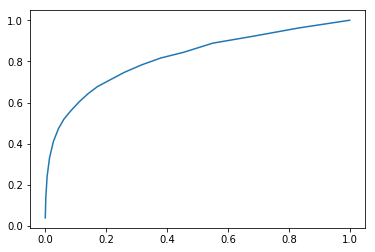

In [19]:
sens = []
spec = []
accu = []
ones = []
for thresh in [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    print("THRESHOLD:",thresh)
    tp = 0
    fp = 0
    fn = 0
    tn = 0
#    for key in conf_dict: # BUT WHAT ABOUT THOSE THAT ARE NOT PREDICTED
#         if float(conf_dict[key]) >= thresh and (key in mal_dict):
#             tp += 1
#         elif float(conf_dict[key]) >= thresh and (key not in mal_dict):
#             fp += 1
#         elif float(conf_dict[key]) < thresh and (key in mal_dict):
#             fn += 1
#         elif float(conf_dict[key]) < thresh and (key not in mal_dict):
#             tn += 1

    for key in range(len(testimages)):
        if predconf[key] >= thresh and gtlabel[key] == 1:
            tp += 1
        elif predconf[key] >= thresh and gtlabel[key] == 0:
            fp += 1
        elif predconf[key] < thresh and gtlabel[key] == 1:
            fn += 1
        elif predconf[key] < thresh and gtlabel[key] == 0:
            tn += 1

    
    print(tp,tn,fp,fn)
    acc = (tp + tn)/len(testimages)
    sen = np.divide(tp, (tp + fn))
    if tn == 0:
        spe = 0
    else:
        spe = np.divide(tn, (tn + fp))
    print("ACCURACY =", acc)
    print("SENSITIVITY =", sen)
    print("SPECIFICITY =", spe)
    accu.append(acc)
    sens.append(sen)
    spec.append(spe)
    ones.append(1)

tpr = np.array(sens)
fpr = np.array(ones) - np.array(spec)
print("ROC CURVE")
plt.plot(fpr, tpr)
print(auc(fpr, tpr))

# LOCALIZATION

In [ ]:
# GENERATE MULTIPLE THRESHOLD FILES:

def generatefile(thresh):
    if net == "YOLO":
        read = open("/home/anvit/Desktop/Scripts/YOLO_output_files/" + outputfilename, 'r')
        outputname = "/home/anvit/Desktop/Scripts/YOLO_output_files/output_yolo_" + str(thresh) + ".txt"
    elif net == "FRCNN":
        read = open("/home/anvit/Desktop/Scripts/FasterRCNN_output_files/" + outputfilename, 'r')
        outputname = "/home/anvit/Desktop/Scripts/FasterRCNN_output_files/output_frcnn_" + str(thresh) + ".txt"
    elif net == "Retinanet":
        read = open("/home/anvit/Desktop/RetinaNet/pytorch-retinanet/output_files/" + outputfilename, 'r')
        outputname = "/home/anvit/Desktop/RetinaNet/pytorch-retinanet/output_files/output_retinanet_" + str(thresh) + ".txt"
    
    write = open(outputname, 'w')
    
    lines = read.readlines()
    for line in lines:
        arr = line.split(",")
        if( float(arr[5]) >= thresh):
            write.write(line)
    read.close()
    write.close()

# 0.001, 0.003, 0.005, 0.007, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9

In [ ]:
generatefile(0.001)
generatefile(0.003)
generatefile(0.005)
generatefile(0.007)
generatefile(0.009)
generatefile(0.01)
generatefile(0.02)
generatefile(0.03)
generatefile(0.04)
generatefile(0.05)
generatefile(0.06)
generatefile(0.07)
generatefile(0.08)
generatefile(0.09)
generatefile(0.1)
generatefile(0.11)
generatefile(0.12)
generatefile(0.13)
generatefile(0.14)
generatefile(0.15)
generatefile(0.16)
generatefile(0.17)
generatefile(0.18)
generatefile(0.19)
generatefile(0.2)
generatefile(0.21)
generatefile(0.22)
generatefile(0.23)
generatefile(0.24)
generatefile(0.25)
generatefile(0.26)
generatefile(0.27)
generatefile(0.28)
generatefile(0.29)
generatefile(0.3)
generatefile(0.31)
generatefile(0.32)
generatefile(0.33)
generatefile(0.34)
generatefile(0.35)
generatefile(0.36)
generatefile(0.37)
generatefile(0.38)
generatefile(0.39)
generatefile(0.4)
generatefile(0.41)
generatefile(0.42)
generatefile(0.43)
generatefile(0.44)
generatefile(0.45)
generatefile(0.46)
generatefile(0.47)
generatefile(0.48)
generatefile(0.49)
generatefile(0.5)
generatefile(0.51)
generatefile(0.52)
generatefile(0.53)
generatefile(0.54)
generatefile(0.55)
generatefile(0.56)
generatefile(0.57)
generatefile(0.58)
generatefile(0.59)
generatefile(0.6)
generatefile(0.61)
generatefile(0.62)
generatefile(0.63)
generatefile(0.64)
generatefile(0.65)
generatefile(0.66)
generatefile(0.67)
generatefile(0.68)
generatefile(0.69)
generatefile(0.7)
generatefile(0.71)
generatefile(0.72)
generatefile(0.73)
generatefile(0.74)
generatefile(0.75)
generatefile(0.76)
generatefile(0.77)
generatefile(0.78)
generatefile(0.79)
generatefile(0.8)
generatefile(0.81)
generatefile(0.82)
generatefile(0.83)
generatefile(0.84)
generatefile(0.85)
generatefile(0.86)
generatefile(0.87)
generatefile(0.88)
generatefile(0.89)
generatefile(0.9)
generatefile(0.91)
generatefile(0.92)
generatefile(0.93)
generatefile(0.94)
generatefile(0.95)
generatefile(0.96)
generatefile(0.97)
generatefile(0.98)
generatefile(0.99)

In [ ]:
# NUM OF FALSE POSTIVE BOXES generated for each test image

pd = []
tpforsens = []
fnforsens = []
tpfpfn = {}
val = number_imgs
print(number_imgs, len(mal_dict))
t = [0.001, 0.003, 0.005, 0.007, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]

for thresh in t:
    
#    print("THRESHOLD,", thresh)
    if net == "YOLO":
        pred_dict, conf_dict = getdicts("output_yolo_" + str(thresh) + ".txt")
    elif net == "FRCNN":
        pred_dict, conf_dict = getdicts("output_frcnn_" + str(thresh) + ".txt")
    elif net == "Retinanet":
        pred_dict, conf_dict = getdicts("output_retinanet_" + str(thresh) + ".txt")

    
    fpcount = 0
    tpcount = 0
    # pi = predicted image
    for pi in pred_dict:
        countedgt = []
        preds = pred_dict[pi]
        conf = conf_dict[pi]
        try:
            gt = mal_dict[pi]
        except:
            fpcount += len(preds)
            continue
        
        orig = len(preds)
        possiblefp = len(preds)
        
        for pred_lesion in preds:
            xmid = (float(pred_lesion[0]) + float(pred_lesion[2]))/2
            ymid = (float(pred_lesion[1]) + float(pred_lesion[3]))/2
            for gt_lesion in gt:
                if [float(gt_lesion[0]), float(gt_lesion[1]), float(gt_lesion[2]), float(gt_lesion[3])] in countedgt:
                    continue
                if ( (xmid >= float(gt_lesion[0]) and xmid <= float(gt_lesion[2])) and (ymid >= float(gt_lesion[1]) and ymid <= float(gt_lesion[3])) ):
                    tpcount += 1
                    possiblefp -= 1
                    countedgt.append([float(gt_lesion[0]), float(gt_lesion[1]), float(gt_lesion[2]), float(gt_lesion[3])])
        fpcount += max(possiblefp,0)
        

    print("Avg number of FP per image =", fpcount/val)
    print("Number of TP =", tpcount)
    
    pd.append(fpcount/val)
    tpforsens.append(tpcount)
    
    fncount = 0
    
    for gti in mal_dict:
        
        gt = mal_dict[gti]
        orig = len(gt)
        possiblefn = len(gt)
        
        try:
            preds = pred_dict[gti]
            for gt_lesion in gt:
                for pred_lesion in preds:
                    xmid = (float(pred_lesion[0]) + float(pred_lesion[2]))/2
                    ymid = (float(pred_lesion[1]) + float(pred_lesion[3]))/2
                    if(xmid >= float(gt_lesion[0]) and xmid <= float(gt_lesion[2])) and (ymid >= float(gt_lesion[1]) and ymid <= float(gt_lesion[3])):
                        possiblefn -= 1
                        break

            fncount += possiblefn
            
        except:
            fncount += possiblefn
            
    print("Number of FN =", fncount)
    fnforsens.append(fncount)
    print("Sensitivity =", tpcount/(tpcount + fncount))

## FROC

In [ ]:
pd = np.array(pd)
tpforsens = np.array(tpforsens)
fnforsens = np.array(fnforsens)
sens_froc = tpforsens/(tpforsens + fnforsens)

indexnearesttofp = -1
indexnearesttosens = -1
difftofp = np.inf
difftosens = np.inf

for i in range(len(t)):
    if abs(pd[i] - 0.3) < difftofp:
        difftofp = abs(pd[i] - 0.3)
        indexnearesttofp = i
    if abs(sens_froc[i] - 0.9) < difftosens:
        difftosens = abs(sens_froc[i] - 0.9)
        indexnearesttosens = i

plt.plot(pd, sens_froc)
plt.xlabel("FP per image")
plt.ylabel("Sensitivity")

ideal_fp_thresh = t[indexnearesttofp]
ideal_fp_fp = pd[indexnearesttofp]
ideal_fp_sens = sens_froc[indexnearesttofp]
ideal_index = (indexnearesttofp + indexnearesttosens) // 2
ideal_thresh = t[ideal_index]
ideal_fp = pd[ideal_index]
ideal_sens = sens_froc[ideal_index]
print(ideal_thresh, ideal_fp, ideal_sens)
print(ideal_fp_thresh, ideal_fp_fp, ideal_fp_sens)

In [ ]:
# NUM OF FALSE POSTIVE BOXES generated for each test image

tpfpfn = {}
thresh = ideal_fp_thresh

if net == "YOLO":
    pred_dict, conf_dict = getdicts("output_yolo_" + str(thresh) + ".txt")
elif net == "FRCNN":
    pred_dict, conf_dict = getdicts("output_frcnn_" + str(thresh) + ".txt")
elif net == "Retinanet":
    pred_dict, conf_dict = getdicts("output_retinanet_" + str(thresh) + ".txt")

tttt = 0
for pi in pred_dict:
    tpforthisimage = 0
    tpfpfn[pi] = {}
    countedgt = []
    preds = pred_dict[pi]
    conf = conf_dict[pi]

    try:
        gt = mal_dict[pi]
    except:
        fpcount += len(preds)
        continue

    orig = len(preds)
    possiblefp = len(preds)

    for pred_lesion in preds:
        xmid = (float(pred_lesion[0]) + float(pred_lesion[2]))/2
        ymid = (float(pred_lesion[1]) + float(pred_lesion[3]))/2
        for gt_lesion in gt:
            if [float(gt_lesion[0]), float(gt_lesion[1]), float(gt_lesion[2]), float(gt_lesion[3])] in countedgt:
                continue
            if ( (xmid >= float(gt_lesion[0]) and xmid <= float(gt_lesion[2])) and (ymid >= float(gt_lesion[1]) and ymid <= float(gt_lesion[3])) ):
                tpforthisimage += 1
                possiblefp -= 1
                countedgt.append([float(gt_lesion[0]), float(gt_lesion[1]), float(gt_lesion[2]), float(gt_lesion[3])])
                
    tpfpfn[pi]["FP"] = max(possiblefp,0)
    tttt += tpfpfn[pi]["FP"]
    tpfpfn[pi]["TP"] = tpforthisimage

print(tttt/number_imgs)

fncount = 0

for gti in mal_dict:
    if gti not in tpfpfn:
        tpfpfn[gti] = {}
        tpfpfn[gti]["TP"] = 0
        tpfpfn[gti]["FP"] = 0
    gt = mal_dict[gti]
    orig = len(gt)
    possiblefn = len(gt)

    try:
        preds = pred_dict[gti]
        for gt_lesion in gt:
            for pred_lesion in preds:
                xmid = (float(pred_lesion[0]) + float(pred_lesion[2]))/2
                ymid = (float(pred_lesion[1]) + float(pred_lesion[3]))/2
                if(xmid >= float(gt_lesion[0]) and xmid <= float(gt_lesion[2])) and (ymid >= float(gt_lesion[1]) and ymid <= float(gt_lesion[3])):
                    possiblefn -= 1
                    break

        fncount += possiblefn
        tpfpfn[gti]["FN"] = possiblefn

    except:
        fncount += possiblefn
        tpfpfn[gti]["FN"] = possiblefn

# VISUALIZATION

In [ ]:
# def vis_detections(im, x1p, x2p, y1p, y2p, x1a, x2a, y1a, y2a, filename):
#     """Draw boxes around detected cancer."""
#     fig,ax=plt.subplots(figsize=(8,10))
#     ax.imshow(im,cmap='gray_r')
#     for i in range(len(x1p)):
#         #if one[i] == 0:
#         ax.add_patch(patches.Rectangle((x1p[i], y1p[i]), x2p[i] - x1p[i], y2p[i] - y1p[i], fill=False, linestyle ='dashed',edgecolor=(0, 1, 0), linewidth=3))
#         #if one[i] == 1:
#         #ax.add_patch(patches.Rectangle((x1p[i], y1p[i]),x2p[i] - x1p[i],y2p[i] - y1p[i], fill=False,edgecolor=(0, 1, 0), linewidth=3))    

#     for i in range(len(x1a)):
#         #if three[i] == 0:
#         ax.add_patch(patches.Rectangle((x1a[i], y1a[i]), x2a[i] - x1a[i], y2a[i] - y1a[i], fill=False, linestyle ='dashed', edgecolor=(1, 0, 0), linewidth=3))
#         #if three[i] == 1:
#         #ax.add_patch(patches.Rectangle((x1a[i], y1a[i]), x2a[i] - x1a[i], y2a[i] - y1a[i], fill=False, edgecolor=(1, 0, 0), linewidth=3))
    
#     plt.axis('off')
#     plt.tight_layout()
#     #plt.savefig("/home/anvit/Desktop/RetinaNet/pytorch-retinanet/Retinanet_vis_smallmass/" + filename + '_vis.jpg')
#     plt.show()
    
def vis_detections_pred(im, x1p, x2p, y1p, y2p, filename):
    """Draw boxes around detected cancer."""
    fig,ax=plt.subplots(figsize=(8,10))
    ax.imshow(im,cmap='gray_r')
    for i in range(len(x1p)):
        #if one[i] == 0:
        ax.add_patch(patches.Rectangle((x1p[i], y1p[i]), x2p[i] - x1p[i], y2p[i] - y1p[i], fill=False, linestyle ='dashed',edgecolor=(0, 1, 0), linewidth=3))
        #if one[i] == 1:
        #ax.add_patch(patches.Rectangle((x1p[i], y1p[i]),x2p[i] - x1p[i],y2p[i] - y1p[i], fill=False,edgecolor=(0, 1, 0), linewidth=3))    
    plt.savefig("/home/anvit/Desktop/Visualisations/Retinanet_missed_20000_aiims/fp/" + filename + '_vis.jpg')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# def vis_detections_actual(im, x1a, x2a, y1a, y2a, filename):
#     """Draw boxes around detected cancer."""
#     fig,ax=plt.subplots(figsize=(8,10))
#     ax.imshow(im,cmap='gray_r')
#     for i in range(len(x1a)):
#         ax.add_patch(patches.Rectangle((x1a[i], y1a[i]), x2a[i] - x1a[i], y2a[i] - y1a[i], fill=False, linestyle ='dashed',edgecolor=(1, 0, 0), linewidth=3))

#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()

In [ ]:
thresh = ideal_fp_thresh

if net == "YOLO":
    pred_dict, conf_dict = getdicts("output_yolo_" + str(thresh) + ".txt")
elif net == "FRCNN":
    pred_dict, conf_dict = getdicts("output_frcnn_" + str(thresh) + ".txt")
elif net == "Retinanet":
    pred_dict, conf_dict = getdicts("output_retinanet_" + str(thresh) + ".txt")


exceptcount = 0
for image in mal_dict:
    tp, fp, fn = tpfpfn[image]["TP"], tpfpfn[image]["FP"], tpfpfn[image]["FN"] 
    try:
        predictions = pred_dict[image]
        xminp = []
        yminp = []
        xmaxp = []
        ymaxp = []
        for box in predictions:
            xminp.append(float(box[0]))
            yminp.append(float(box[1]))
            xmaxp.append(float(box[2]))
            ymaxp.append(float(box[3]))

        gts = mal_dict[image]
        xmina = []
        ymina = []
        xmaxa = []
        ymaxa = []
        for lesion in gts:
            xmina.append(float(lesion[0]))
            ymina.append(float(lesion[1]))
            xmaxa.append(float(lesion[2]))
            ymaxa.append(float(lesion[3]))


        im = cv2.imread(data_img_path + image + ".png")

        vis_detections(im, xminp, xmaxp, yminp, ymaxp, xmina, xmaxa, ymina, ymaxa, image)
        print(image, "TP:", tp, "FP:", fp, "FN:", fn)
        

    except:
        gts = mal_dict[image]
        
        xmina = []
        ymina = []
        xmaxa = []
        ymaxa = []
        for lesion in gts:
            xmina.append(float(lesion[0]))
            ymina.append(float(lesion[1]))
            xmaxa.append(float(lesion[2]))
            ymaxa.append(float(lesion[3]))
            
        exceptcount += 1
        im = cv2.imread(data_img_path + image + ".png")        
        vis_detections_actual(im, xmina, xmaxa, ymina, ymaxa, image)
        print(image, "TP:", tp, "FP:", fp, "FN:", fn)
        continue


In [ ]:
keep = 0
for i in mal_dict:
    if i not in pred_dict:
        keep += 1
print(keep, "out of", len(mal_dict))
print(exceptcount, "out of", len(mal_dict))
assert(exceptcount == keep)

In [ ]:
# with open('masscallabels.pk', 'rb') as handle:
#     d_masscal = pickle.load(handle)
# with open('benmallabels.pk', 'rb') as handle:
#     d_benmal = pickle.load(handle)
    # -1 is normal, 0 is benign, 1 is malignant
#print(d_masscal, d_benmal)

# MASS VS CAL

In [ ]:
actualfileformasscal = "/home/anvit/Desktop/RetinaNet/pytorch-retinanet/csv_annotation_AIIMS_masscal.csv"
if net == "Retinanet":
    outputfileformasscal = "/home/anvit/Desktop/RetinaNet/pytorch-retinanet/output_files/output_retinanet_" + str(ideal_fp_thresh) + ".txt"
elif net == "FRCNN":
    outputfileformasscal = "/home/anvit/Desktop/Scripts/FasterRCNN_output_files/output_frcnn_" + str(ideal_fp_thresh) + ".txt"
predictions = open(outputfileformasscal, 'r')
actual = open(actualfileformasscal, 'r')
lines_pred = predictions.readlines()
lines_actual = actual.readlines()

actual.close()
predictions.close()

In [ ]:
pred_dict = {}
conf_dict = {}
#predlabel_dict = {}
for line in lines_pred:
    line = line.rstrip()
    det = line.split(',')
    if (net == "Retinanet" and det[6] == "0"):
        # If it predicted as benign, ignore the prediction
        continue
    if(det[0][:-4] not in pred_dict):
        pred_dict[det[0][:-4]] = [[float(det[1]), float(det[2]), float(det[3]), float(det[4])]]
        conf_dict[det[0][:-4]] = [float(det[5])]
        #predlabel_dict[det[0][:-4]] = [float(det[6])]
    else:
        pred_dict[det[0][:-4]].append([float(det[1]), float(det[2]), float(det[3]), float(det[4])])
        conf_dict[det[0][:-4]].append(float(det[5]))
        #predlabel_dict[det[0][:-4]].append(float(det[6]))

In [ ]:
masscal_dict = {}
for xml in os.listdir("/home/anvit/Desktop/Data/AIIMS_Data/Both_labelled/AllSetsXMLs_withmasscal_resized/"):
    tree = ET.parse("/home/anvit/Desktop/Data/AIIMS_Data/Both_labelled/AllSetsXMLs_withmasscal_resized/" + xml)
    root = tree.getroot()
    numob = 0
    
    for obj in root.findall("object"):
        numob += 1
    
    if numob > 0:
        masscal_dict[xml[:-4]] = {}
    elif numob == 0:
        print(xml)
        print("this image has an xml file with no objects")
        continue

    for obj in root.findall("object"):
        if obj[0].text != "MASS" and obj[0].text != "CALCIFICATION":
            continue

        label = obj[0].text
        bbox = obj[4]
        xmin = float(bbox[0].text)
        ymin = float(bbox[1].text)
        xmax = float(bbox[2].text)
        ymax = float(bbox[3].text)
        s = [xmin, ymin, xmax, ymax]
        listTostr = ' '.join([str(elem) for elem in s])
        masscal_dict[xml[:-4]][listTostr] = label

In [ ]:
#GT
actual_dict = {}
#actuallabel_dict = {}
for line in lines_actual:
    line = line.rstrip()
    det = line.split(',')
    path = det[0].split("/")
    if det[5] == "1":
        # Put only malignant lesions into the dict
        if(path[-1][:-4] not in actual_dict):
                actual_dict[path[-1][:-4]] = [[float(det[1]), float(det[2]), float(det[3]), float(det[4])]]
                #actuallabel_dict[path[-1][:-4]] = [float(det[5])]
        else:
            actual_dict[path[-1][:-4]].append([float(det[1]), float(det[2]), float(det[3]), float(det[4])])
            #actuallabel_dict[path[-1][:-4]].append(float(det[5]))

In [ ]:
num_mal = 0
num_mass = 0
num_cal = 0

for k in actual_dict:
    les = actual_dict[k]
    #l = actuallabel_dict[k]
    mc = masscal_dict[k]
    num_mal += len(les)
    for e in range(len(les)):
        listTostr = ' '.join([str(elem) for elem in les[e]])
        
        if mc[listTostr] == "MASS":
            num_mass +=1
        elif mc[listTostr] == "CALCIFICATION":
            num_cal +=1

In [ ]:
mal_as_mal = 0
malmass_as_mal = 0
malcal_as_mal = 0
nobox = 0

for img in actual_dict:
    lesions = actual_dict[img]
    masscalinfo = masscal_dict[img]
    
    try:
        pred_lesions = pred_dict[img]
        pred_confs = conf_dict[img]
    
    except:
        nobox += len(lesions)
        continue

    for i in range(len(lesions)):
        flag = False

        lesion = lesions[i]
        xmin, ymin, xmax, ymax = lesion
        listTostr = ' '.join([str(elem) for elem in lesion])
        massorcal = masscalinfo[listTostr]        
        
        cnt = 0
        for j in range(len(pred_lesions)):
            xminp, yminp, xmaxp, ymaxp = pred_lesions[j]
            midx, midy = (xminp + xmaxp)/2, (yminp + ymaxp)/2
            if midx > xmin and midx < xmax and midy > ymin and midy < ymax:                
                mal_as_mal += 1
                if massorcal == "MASS":
                    malmass_as_mal += 1
                elif massorcal == "CALCIFICATION":
                    malcal_as_mal += 1
                flag = True

            else:
                cnt += 1
            if flag == True:
                break
        
        if cnt == len(pred_lesions):
            nobox += 1

In [ ]:
print("Number of malignant lesions:", num_mal)
print("Number of malignant masses:", num_mass)
print("Number of malignant calcifications:", num_cal)

print("Number of malignant lesions correctly predicted as malignant:", mal_as_mal, "out of:", num_mal)
print("Number of malignant masses correctly predicted as malignant:", malmass_as_mal, "out of:", num_mass)
print("Number of malignant calcifications correctly predicted as malignant:", malcal_as_mal, "out of:", num_cal)
print("Number of malignant lesions not predicted:", nobox, "out of:", num_mal)

assert num_mal == num_mass + num_cal
assert mal_as_mal == malmass_as_mal + malcal_as_mal
assert num_mal == mal_as_mal + nobox

In [20]:
thresh=0.35
print("THRESHOLD:",thresh)
fpnames=[]
fnnames=[]
for key in range(len(testimages)):
    if predconf[key] >= thresh and gtlabel[key] == 0:
        fp += 1
        fpnames.append(testimages[key])
    elif predconf[key] < thresh and gtlabel[key] == 1:
        fn += 1
        fnnames.append(testimages[key])
        
dest="/home/anvit/Desktop/Visualisations/woBoxes/"+net+"_missed_20000_aiims/fp/"
for image in fpnames:
    copyfile(os.path.join(data_img_path,image),dest+ image[:-4] + '_vis.png')
    
dest="/home/anvit/Desktop/Visualisations/woBoxes/"+net+"_missed_20000_aiims/fn/"
for image in fnnames:
    copyfile(os.path.join(data_img_path,image),dest+ image[:-4] + '_vis.png')

THRESHOLD: 0.35


In [ ]:
thresh=0.001
def vis_detections_pred(im, x1p, x2p, y1p, y2p, filename,dest):
    """Draw boxes around detected cancer."""
    fig,ax=plt.subplots(figsize=(8,10))
    ax.imshow(im,cmap='gray_r')
    for i in range(len(x1p)):
        #if one[i] == 0:
        ax.add_patch(patches.Rectangle((x1p[i], y1p[i]), x2p[i] - x1p[i], y2p[i] - y1p[i], fill=False, linestyle ='dashed',edgecolor=(0, 1, 0), linewidth=3))
        #if one[i] == 1:
        #ax.add_patch(patches.Rectangle((x1p[i], y1p[i]),x2p[i] - x1p[i],y2p[i] - y1p[i], fill=False,edgecolor=(0, 1, 0), linewidth=3))    
    plt.savefig(dest+ filename[:-4] + '_vis.png')
    plt.axis('off')
    plt.tight_layout()
#     plt.show()

if net == "YOLO":
    pred_dict, conf_dict = getdicts("output_yolo_" + str(thresh) + ".txt")
elif net == "FRCNN":
    pred_dict, conf_dict = getdicts("output_frcnn_" + str(thresh) + ".txt")
elif net == "Retinanet":
    pred_dict, conf_dict = getdicts("output_retinanet_" + str(thresh) + ".txt")


exceptcount = 0
dest="/home/anvit/Desktop/Visualisations/woBoxes/FRCNN_missed_20000_aiims/fp/"
for image in fpnames:
    print(image)
    try:
        predictions = pred_dict[image[:-4]]
        xminp = []
        yminp = []
        xmaxp = []
        ymaxp = []
        for box in predictions:
            xminp.append(float(box[0]))
            yminp.append(float(box[1]))
            xmaxp.append(float(box[2]))
            ymaxp.append(float(box[3]))

        im = cv2.imread(os.path.join(data_img_path,image))

        vis_detections_pred(im, xminp, xmaxp, yminp, ymaxp, image,dest)
        

    except:
        copyfile(os.path.join(data_img_path,image),dest+ image[:-4] + '_vis.png')
        continue
dest="/home/anvit/Desktop/Visualisations/woBoxes/FRCNN_missed_20000_aiims/fn/"
for image in fnnames:
    print(image)
    try:
        predictions = pred_dict[image[:-4]]
        xminp = []
        yminp = []
        xmaxp = []
        ymaxp = []
        for box in predictions:
            xminp.append(float(box[0]))
            yminp.append(float(box[1]))
            xmaxp.append(float(box[2]))
            ymaxp.append(float(box[3]))

        im = cv2.imread(os.path.join(data_img_path,image))

        vis_detections_pred(im, xminp, xmaxp, yminp, ymaxp, image,dest)
        

    except:
        copyfile(os.path.join(data_img_path,image),dest+ image[:-4] + '_vis.png')
        continue
